Render

In [1]:
import importlib
import os
from tkinter import NO
import yaml
import argparse
from datetime import datetime

from sacd.env import make_pytorch_env
from sacd.agent import SacdAgent, SharedSacdAgent


import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
# import gymnasium as gym
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT
from datetime import datetime
import cv2
from tqdm import tqdm
import numpy as np
from datetime import datetime
from gym.wrappers import GrayScaleObservation
from smb_env_fct import renderEnv, plotRewardandTime, DeadlockEnv, SkipFrame, Downsample, GrayScale, move_state_channels, MarioDeathLoggerWrapper, RandomEnvWrapper, RewardPlusEnv


/home/gong/miniconda3/envs/sacd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '--config', type=str, default=os.path.join('config', 'sacd.yaml'))
parser.add_argument('--shared', action='store_true')
parser.add_argument('--env_id', type=str, default='SuperMarioBros-v2')
parser.add_argument('--log_folder', type=str, default='logs')
parser.add_argument('--cuda', action='store_true')
parser.add_argument('--seed', type=int, default=0)
args, unknown = parser.parse_known_args()

with open(args.config) as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [3]:
frameskip = 4
# load_model_path = "model/SuperMarioBrosRandomStages-v2"
# load_model_path = "model/SuperMarioBros-v2"
load_model_path = "logs/SuperMarioBrosRandomStages-v2/sacd-seed0-20240705-2321/model/best"
# load_model_path = "/mnt/f/master/semester_4_24SS/KR_seminar/model/random32-3l"
load_model_path = "logs/SuperMarioBrosRandomStages-v2/sacd-seed0-20240707-0112/model/best"


# Specify the directory to log.
name = args.config.split('/')[-1].rstrip('.yaml')
if args.shared:
    name = 'shared-' + name
time = datetime.now().strftime("%Y%m%d-%H%M")
log_dir = os.path.join(
    args.log_folder, args.env_id, f'{name}-seed{args.seed}-{time}')

logfile = f"{log_dir}/mario_death_logfile_{time}.txt"

In [4]:
env = gym_super_mario_bros.make(args.env_id, apply_api_compatibility=True)  #the environment. v0 is with original background, v1 has the background removed
# env = gym_super_mario_bros.make("SuperMarioBros-1-1-v2", apply_api_compatibility=True)
# stages = ['1-1', '1-2', '1-3']
# env = RandomEnvWrapper(args.env_id, stages)
env = JoypadSpace(env, SIMPLE_MOVEMENT)               #The Joypadspace sets the available actions. We use SIMPLE_MOVEMENT.
env = SkipFrame(env, skip=frameskip)                  #Skipframewrapper to skip some frames
env = DeadlockEnv(env,threshold=(60*2)//frameskip)                   #Deadlock environment wrapper to stop the game if mario is stuck at a pipe
env = RewardPlusEnv(env)
env = MarioDeathLoggerWrapper(env, logfile=logfile, env_id=None, select_random_stage=True)

/home/gong/miniconda3/envs/sacd/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v2 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


In [5]:
# Specify the directory to log.
name = args.config.split('/')[-1].rstrip('.yaml')
if args.shared:
    name = 'shared-' + name
time = datetime.now().strftime("%Y%m%d-%H%M")
log_dir = os.path.join(
    'logs', args.env_id, f'{name}-seed{args.seed}-{time}')

# Create the agent.
Agent = SacdAgent if not args.shared else SharedSacdAgent
agent = Agent(
    env=env, test_env=env, log_dir=log_dir, cuda=args.cuda,
    seed=args.seed, **config)

In [13]:
# agent.evaluate()
agent.load_models(load_model_path)
agent.testnshow()
# del agent

/home/gong/miniconda3/envs/sacd/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


mean return: 363.8
max return: 730.8


Exception ignored in: <function BaseAgent.__del__ at 0x7fd2a6e241f0>
Traceback (most recent call last):
  File "/home/gong/Projects/sac-discrete-pytorch/sacd/agent/base.py", line 283, in __del__
    self.test_env.close()
  File "/home/gong/miniconda3/envs/sacd/lib/python3.9/site-packages/gym/core.py", line 333, in close
    return self.env.close()
  File "/home/gong/miniconda3/envs/sacd/lib/python3.9/site-packages/gym/core.py", line 333, in close
    return self.env.close()
  File "/home/gong/miniconda3/envs/sacd/lib/python3.9/site-packages/gym/core.py", line 333, in close
    return self.env.close()
  [Previous line repeated 4 more times]
  File "/home/gong/miniconda3/envs/sacd/lib/python3.9/site-packages/gym/wrappers/compatibility.py", line 122, in close
    self.env.close()
  File "/home/gong/miniconda3/envs/sacd/lib/python3.9/site-packages/nes_py/nes_env.py", line 346, in close
    raise ValueError('env has already been closed.')
ValueError: env has already been closed.


returns

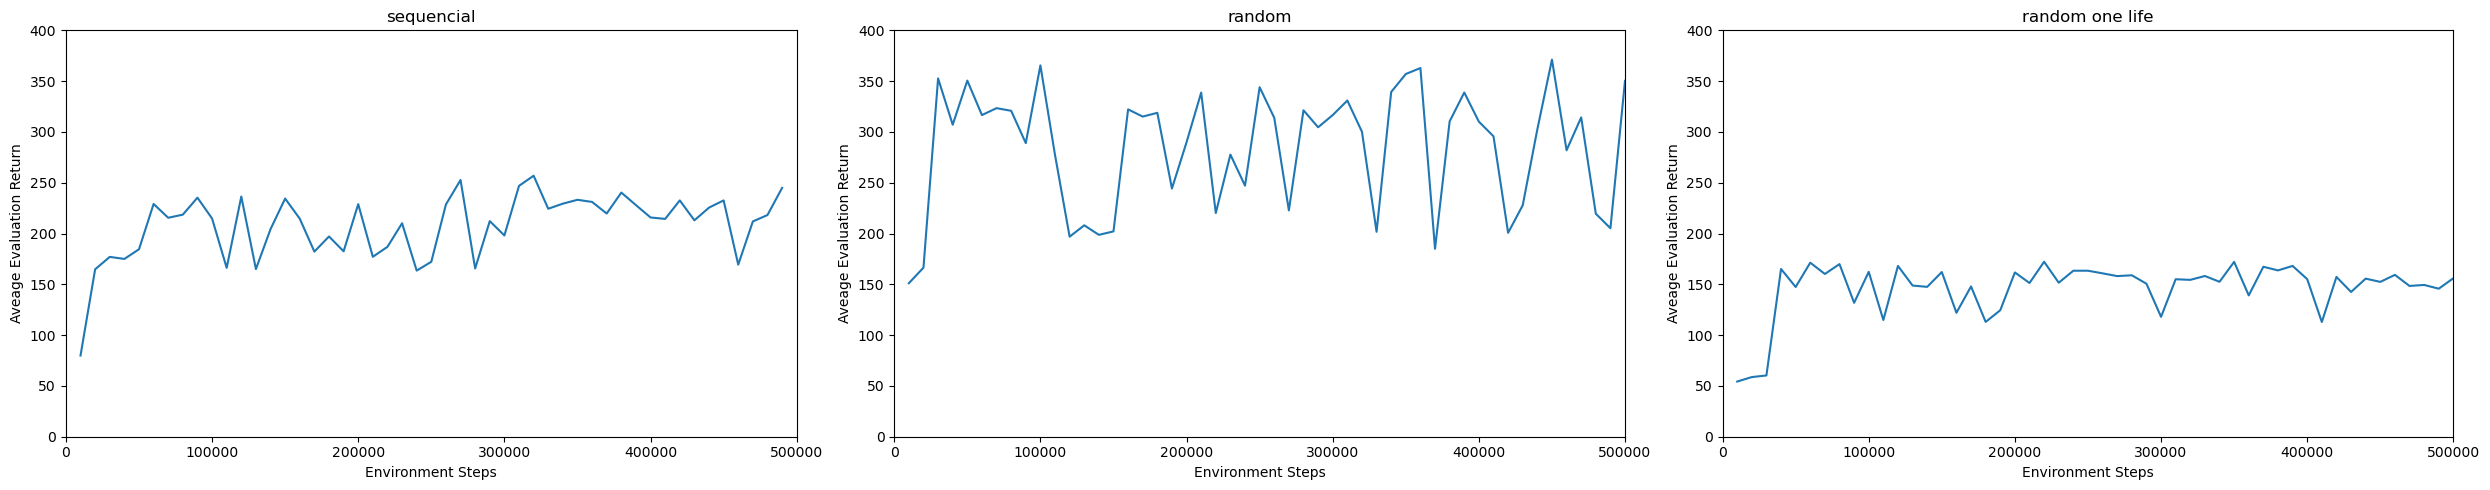

In [10]:
import matplotlib.pyplot as plt

# 文件路径列表
file_paths = ['logs/SuperMarioBros-v2/sacd-seed0-20240705-0754/returns_log.txt', 
              'logs/SuperMarioBrosRandomStages-v2/random3lives.txt', 
              'logs/SuperMarioBrosRandomStages-v2/sacd-seed0-20240705-2321/returns_log.txt']
titles = ["sequencial", "random", "random one life"]

# 设置绘图
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

for i, file_path in enumerate(file_paths):
    steps = []
    returns = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith('Num steps:'):
                parts = line.split()
                steps.append(int(parts[2]))
                returns.append(float(parts[4]))

    ax = axs[i]
    # ax.plot(steps, returns, label='Aveage Evaluation Return')
    ax.plot(steps, returns)
    ax.set_title(titles[i])
    ax.set_xlabel('Environment Steps')
    ax.set_ylabel('Aveage Evaluation Return')
    ax.set_xlim((0, 500000))
    ax.set_ylim((0, 400))
    # ax.legend()

plt.tight_layout()
plt.show()


In [6]:
agent.load_models(load_model_path)
num_episodes = 0
num_steps = 0
total_return = 0.0
episode_list = []


while True:
    frames = []
    state, _ = env.reset()
    frame = state.copy()
    # frames.append(frame)
    state = move_state_channels(state)

    episode_steps = 0
    episode_return = 0.0
    done = False
    while (not done):
        action = agent.exploit(state.copy())
        next_state, reward, done, info = env.step(action)
        episode_return += reward


        
        # 创建信息板
        info_board = np.zeros((frame.shape[0], 300, 3), dtype=np.uint8)
        
        # 显示动作
        cv2.putText(info_board, f'Action: {action}', (10, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
        # 显示返回值
        cv2.putText(info_board, f'Reward: {reward:.2f}', (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(info_board, f'Done: {done}', (10, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(info_board, f'Sum R.: {episode_return:.2f}', (10, 75), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
        # 显示字典中的所有键值对
        y_offset = 15
        for key, value in info.items():
            text = f'{key}: {value}'
            cv2.putText(info_board, text, (160, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            y_offset += 20        
        # 合并游戏帧和信息板
        combined_frame = np.hstack((frame, info_board))
        frames.append(combined_frame)
        frame = next_state.copy()




        # if not done:
        #     frames.append(next_state.copy())
        
        next_state = move_state_channels(next_state)
        num_steps += 1
        episode_steps += 1
        # episode_return += reward
        state = next_state

    num_episodes += 1
    total_return += episode_return
    # print("episode: {} episode return: {}".format(num_episodes, episode_return))

    if len(frames) > 0:
        episode_list.append((episode_return,frames))

    if num_steps > config["num_eval_steps"]:
    # if num_steps > 500:
        break

mean_return = total_return / num_episodes
print(f'mean return: {mean_return:<5.1f}')

if len(episode_list) > 0:
    episode_list.sort(key=lambda x: x[0])
    print(f'max return: {episode_list[-1][0]:<5.1f}')
    renderEnv(episode_list[-1][1])
else:
    print("no available video")


/home/gong/miniconda3/envs/sacd/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


mean return: 324.9
max return: 642.8
